<a href="https://colab.research.google.com/github/duyqu-chan/Experiments-with-XGBoost/blob/master/scienceWave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Science Wave Capital - Case Study
31.08.2018

by Duygu Can

The aim of this study is to minimize multinominal cross-entropy, using 103 features given in trainData.csv with the help of state-of-art feature engineering, ML modelling and ensembling techniques.
For this reason powerfull XGBoost algorithm is chosen.


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import skew, mstats, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [0]:
train = pd.read_csv("trainData.csv")
test = pd.read_csv("testData.csv")
y = train.target
X = train.drop('target', axis=1)
X.head()
X_trans = BCtrans(X)

,v1,v10,v100,v101,v102,v103,v11,v12,v13,v14,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,1.4,0.0,0.2,1.0,4.2,0.4,0.0,0.0,0.0,1.2,...,0.2,0.6,0.2,0.0,3.2,1.0,0.2,0.0,1.6,0.4
1,0.0,0.0,0.0,2.8,0.0,0.8,0.0,0.2,1.2,1.4,...,0.0,0.0,0.0,1.2,0.0,1.2,0.2,0.2,2.6,2.2
2,0.0,0.0,0.0,0.4,0.0,0.6,0.8,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.8,0.2,0.8,1.4,0.0
3,0.0,0.0,0.0,0.0,0.2,0.8,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.4,0.4,0.0,0.4,0.4,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.4,0.0


Transform categories to 0-8

In [0]:
y = y-1

Class Weights:

In [0]:
y.value_counts(normalize="TRUE").sort_index()


0    0.031174
1    0.260545
2    0.129351
3    0.043489
4    0.044265
5    0.228433
6    0.045881
7    0.136785
8    0.080077
Name: target, dtype: float64

## Preprocess

To normalize the distributions apply box-cox transformation.

In [0]:
def BCtrans(X):
    '''A function to columnwise box-cox transform and scale  a dataframe'''
    Xt = pd.DataFrame(index=X.index, columns=X.columns)
    eps = 1e-7 # a very small number to shift the range
    scaler = MinMaxScaler(feature_range=(0+eps, 1)) #1st scaler (box-cox requires sitrictly positive range
    scaler2 = MinMaxScaler(feature_range=(0, 1)) #2nd scaler
    for col in X.columns: #loop over columns
        scaled = scaler.fit_transform(X[col].values.reshape(-1, 1))
        trans, _ = stats.boxcox(scaled) #apply box-cox transformation
        Xt[col] = scaler2.fit_transform(trans.reshape(-1, 1))
   
    return Xt
    #Xtrain_trans = pd.DataFrame(Xtrain_trans, columns=colNames)#convert array to dataframe

In [0]:
X_trans = BCtrans(X)

### Outliers

In [0]:
def doubleMAD(x):
    m = median(x)
    absDev = abs(x-m)
    MAD_L = median(absDev[x<=m]) #left mean abs dev (MAD)
    MAD_R = median(absDev[x>m]) #right MAD
    return (MAD_L,MAD_R)

In [0]:
def doubleMADfromMed(x):
    MAD_L,MAD_R = doubleMAD(x)#find MADs for both x<=m and x>m
    #print(MAD_L,MAD_R)
    m = median(x)# calc median
    distance = [0]*len(x) #set distance to 0 to avoid taggin x's w/ 0 MADs as outliers (since threshold=3 or 3.5 )
    if MAD_L!=0 and MAD_R!=0:
        xMAD = [MAD_L]*len(x)
        for i in range(len(x)):
            if x[i]>m: 
                xMAD[i] = MAD_R   
            distance[i] =  abs(x[i]-m)/xMAD[i]#update distance value for non-zero MADs  
            
    return np.array(distance) 

In [0]:
def handleOutliers(x):
    dist = doubleMADfromMed(x)
    if len(dist)/len(x) <= 0.1: # if number of outliers found is way too MUCH
                                # dont change anything, probably they are not outliers
                                #otherwise 12
        x[dist>=3.5] = median(x) #replace detected outliers w/ median values 
    return x

In [0]:
tic = time.clock() #initialize timer
X_trans2 =  X_trans

for v in X_trans2.keys():
    MAD_L,MAD_R = doubleMAD(X_trans2[v])
    if MAD_L != 0 and MAD_R != 0: #check only the columns w/ non-zero MADs
        #print(f"calculating for {v}")
        X_trans2[v] = handleOutliers(X_trans2[v])    
        
toc = time.clock() 
deltaT = toc - tic #calculate time passed
print("Time passed:", deltaT)

Time passed: 8.96455200339551


In [0]:
def sampleWeight(y):
    wArr=[]
    classWeight = y.value_counts(normalize="TRUE").sort_index()
    for i in range(len(y)):
        cls = y[i]
        prob = classWeight[cls]
        wArr.append(1/prob) #sampling weights are the inverse of the likelihood of being sampled
        
    return wArr
    

Generate weight column

In [0]:
X["Weight"] = sampleWeight(y)
X_trans2["Weight"] = sampleWeight(y)

In [0]:
# Raw data w/o any preprocess
X_trainR, X_valR, y_trainR, y_valR = train_test_split(X,y,test_size = 0.20,stratify=y, random_state=42)
# Preprocessed data
X_train, X_val, y_train, y_val = train_test_split(X_trans2,y,test_size = 0.20,stratify=y, random_state=42)

With stratified split, all the sets have the same class distributions

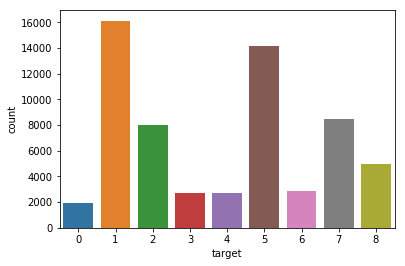

In [0]:
sns.countplot(y)

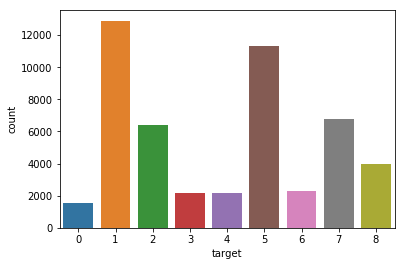

In [0]:
sns.countplot(y_train)

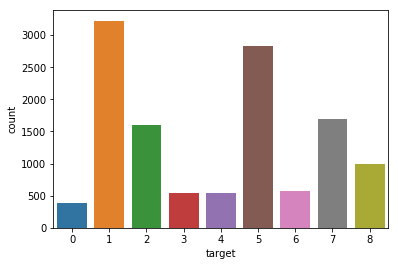

In [0]:
sns.countplot(y_val)

Convert to Dmatrices using weights:

In [0]:
weightsTrainR = X_trainR["Weight"]
weightsValR = X_valR["Weight"]
weightsTrain = X_train["Weight"]
weightsVal = X_val["Weight"]
X_trainR=X_trainR.drop("Weight", axis=1)
X_train=X_train.drop("Weight", axis=1)
X_val=X_val.drop("Weight", axis=1)
X_valR=X_valR.drop("Weight", axis=1)

#Raw data
dtrainR = xgb.DMatrix(X_trainR.values, label=y_trainR.values, weight = list(weightsTrainR))
dvalR = xgb.DMatrix(X_valR.values, label=y_valR.values, weight = list(weightsValR))

#Preprocessed data:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values, weight = list(weightsTrain)) 
dval = xgb.DMatrix(X_val.values, label=y_val.values, weight = list(weightsVal))

## Base Model

### Finding Optimal *early_stopping_rounds* and Deciding Whether to Work w/ PP Data

User default values for the parameters. Set number of boosting rounds to a large value hoping to find the optimal number of rounds before reaching it, if we haven't improved performance on our test dataset in early_stopping_round rounds. 

**For raw data:** 

*early_stopping_rounds=50*

Overfits when early stopping is 50. test mlogloss is different than logloss score i printed! why?

Stopping. Best iteration:
[91]	Train-mlogloss:0.262372	Test-mlogloss:0.574462

Precision Score of the Training Set=  0.9050336943489816
Precision Score of the Validation Set=  0.7686466309247741
Recall Score of the Training Set=  0.9475262446092757
Recall Score of the Validation Set=  0.7977945722645391
F1 Score of the Training Set=  0.9232506310734429
F1 Score of the Validation Set=  0.7810360100814073
Accuracy Score the Training Set=  0.9212557068401277
Accuracy Score of the Validation Set=  0.8074499030381384
Logloss Score Training Set=  0.23754421251685748
Logloss Score of the Validation Set=  0.5183675200240478

*early_stopping_rounds=20*

Still overfits, bur train-val err gap shrinks a little. Go with 20!

Stopping. Best iteration:
[91]	Train-mlogloss:0.262372	Test-mlogloss:0.574462

Precision Score of the Training Set=  0.8826887102750479
Precision Score of the Validation Set=  0.7601492425344746
Recall Score of the Training Set=  0.9332710752015125
Recall Score of the Validation Set=  0.7954885367702247
F1 Score of the Training Set=  0.9036441266119595
F1 Score of the Validation Set=  0.7746942151975973
Accuracy Score the Training Set=  0.9047109207708779
Accuracy Score of the Validation Set=  0.8023594053005818
Logloss Score Training Set=  0.2809365021279182
Logloss Score of the Validation Set=  0.5271007130528547

**For preprocessed data:** 

A very slight improvement when othet metrics are watched :/ 
I still choose to study with preprocessed data.

*early_stopping_rounds=20*

Stopping. Best iteration:
[95]	Train-mlogloss:0.25647	Test-mlogloss:0.579169

Precision Score of the Training Set=  0.883825216224297
Precision Score of the Validation Set=  0.7623610899980903
Recall Score of the Training Set=  0.9347575557053869
Recall Score of the Validation Set=  0.7974404086630739
F1 Score of the Training Set=  0.9048876737998365
F1 Score of the Validation Set=  0.7767074320735438
Accuracy Score the Training Set=  0.9066502363540867
Accuracy Score of the Validation Set=  0.8039754363283775
Logloss Score Training Set=  0.2761034465086731
Logloss Score of the Validation Set=  0.5271038199094024

In [0]:
params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 6,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':1,
    'gamma':0.0,
    'subsample':1,
    'colsample_bytree':1,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)


[0]	Train-mlogloss:1.5964	Test-mlogloss:1.6202
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:1.35619	Test-mlogloss:1.39182
[2]	Train-mlogloss:1.19177	Test-mlogloss:1.23765
[3]	Train-mlogloss:1.07043	Test-mlogloss:1.12436
[4]	Train-mlogloss:0.976215	Test-mlogloss:1.04053
[5]	Train-mlogloss:0.9014	Test-mlogloss:0.972382
[6]	Train-mlogloss:0.842532	Test-mlogloss:0.919265
[7]	Train-mlogloss:0.791158	Test-mlogloss:0.874871
[8]	Train-mlogloss:0.749256	Test-mlogloss:0.839669
[9]	Train-mlogloss:0.71311	Test-mlogloss:0.809282
[10]	Train-mlogloss:0.68242	Test-mlogloss:0.785452
[11]	Train-mlogloss:0.65536	Test-mlogloss:0.763842
[12]	Train-mlogloss:0.631932	Test-mlogloss:0.744633
[13]	Train-mlogloss:0.610872	Test-mlogloss:0.728672
[14]	Train-mlogloss:0.593442	Test-mlogloss:0.715198
[15]	Train-mlogloss:0.577366	Test-mlogloss:0.703243
[16]	Train-mlogloss:0.563679	Test-mlogloss:

A function to pass instance weights while CV.

In [0]:
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    #ratio = float(np.sum(label == 0)) / np.sum(label==1)
    #param['scale_pos_weight'] = ratio
    wtrain = dtrain.get_weight()
    wtest = dtest.get_weight()
    sum_weight = sum(wtrain) + sum(wtest)
    wtrain *= sum_weight / sum(wtrain)
    wtest *= sum_weight / sum(wtest)
    dtrain.set_weight(wtrain)
    dtest.set_weight(wtest)
    return (dtrain, dtest, param)

Confusion Matrices:

In [0]:
print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

Confusion Matrix of the Training Set: 

[[ 1515     0     1     0     0     1    10    10     6]
 [   18 10260  1801   611    12     2   152    13    29]
 [    5   610  5414   273     0     0    96     4     1]
 [    4    62    81  1999     0     0     7     0     0]
 [    1     0     0     0  2188     0     2     0     0]
 [  102    14    10    14     2 10963    85    69    49]
 [   18    17    23    22     1     4  2184     1     1]
 [  118    14    16     1     2    15    46  6515    44]
 [   71    12     2     6     0     4    10    16  3843]]
Confusion Matrix of the Validation Set: 

[[ 264    5    2    4    0   15   13   36   47]
 [   9 2259  670  192    5    9   60    8   12]
 [   1  350 1047  118    0    4   71    5    5]
 [   0   57   75  380    0    9   15    0    2]
 [   2    3    0    0  541    1    1    0    0]
 [  31   11    6    8    0 2643   42   41   45]
 [  25   23   47   10    3   15  415   22    8]
 [  59    7    5    0    0   28   27 1538   29]
 [  63    5    0    

5-fold CV with the same parameters with predefined weights

In [0]:
xgb.cv(params, dtrain, num_round, nfold=5, stratified=True, early_stopping_rounds=20,
       metrics="mlogloss", seed = 42, fpreproc = fpreproc)

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.621867,0.004641,1.592724,0.001862
1,1.392555,0.005024,1.348014,0.001800
2,1.240216,0.005668,1.183735,0.001577
3,1.129256,0.006175,1.061124,0.002383
4,1.045067,0.006519,0.966904,0.002337
5,0.978236,0.006330,0.890904,0.001889
6,0.925011,0.006669,0.829489,0.001822
7,0.881365,0.006890,0.778292,0.002053
8,0.845677,0.007813,0.735576,0.001418
9,0.815931,0.008294,0.699266,0.001449


Let's see what cross-validation score we get with our current parameters. Unfortunately, there is no nthread parameter to be set for cv method.

Let's make a list containing all the combinations max_depth/min_child_weight that we want to try.

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,9,2)
    for min_child_weight in range(1,6,2)
]

Best params: 5, 3, mlogloss: 0.5892252 GridsearchCV de min loss u veren parametreleri best olarak seçiyor.

In [0]:
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_mlogloss))

CV with max_depth=3, min_child_weight=1
[0]	train-mlogloss:1.73069+0.001075	test-mlogloss:1.73607+0.00265613
[10]	train-mlogloss:0.94512+0.00248545	test-mlogloss:0.971084+0.00580815
[20]	train-mlogloss:0.781473+0.00253195	test-mlogloss:0.820804+0.00544105
[30]	train-mlogloss:0.705435+0.00261178	test-mlogloss:0.757391+0.00510114
[40]	train-mlogloss:0.657154+0.00195872	test-mlogloss:0.721251+0.00540582
[50]	train-mlogloss:0.621849+0.00190172	test-mlogloss:0.696674+0.00514572
[60]	train-mlogloss:0.594264+0.00170787	test-mlogloss:0.678219+0.00527975
[70]	train-mlogloss:0.571425+0.00168668	test-mlogloss:0.664258+0.00463174
[80]	train-mlogloss:0.552201+0.00216229	test-mlogloss:0.653509+0.00459371
[90]	train-mlogloss:0.53483+0.00206309	test-mlogloss:0.644261+0.00448913
[100]	train-mlogloss:0.519168+0.00182767	test-mlogloss:0.636488+0.00502219
[110]	train-mlogloss:0.50532+0.00186956	test-mlogloss:0.630407+0.00486039
[120]	train-mlogloss:0.4931+0.00150865	test-mlogloss:0.625323+0.00516363
[130]

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	mlogloss 0.5935242 for 307 rounds
CV with max_depth=3, min_child_weight=3
[0]	train-mlogloss:1.73069+0.001075	test-mlogloss:1.73607+0.00265613
[10]	train-mlogloss:0.944985+0.00241862	test-mlogloss:0.970946+0.00563399
[20]	train-mlogloss:0.781622+0.00239637	test-mlogloss:0.820855+0.00537131
[30]	train-mlogloss:0.705836+0.00239016	test-mlogloss:0.758684+0.00605133
[40]	train-mlogloss:0.657522+0.00197529	test-mlogloss:0.721929+0.00634543
[50]	train-mlogloss:0.622429+0.00209208	test-mlogloss:0.697337+0.00638251
[60]	train-mlogloss:0.594504+0.00186124	test-mlogloss:0.678717+0.00599008
[70]	train-mlogloss:0.571256+0.00162674	test-mlogloss:0.664108+0.0060512
[80]	train-mlogloss:0.552024+0.00196599	test-mlogloss:0.653202+0.00550149
[90]	train-mlogloss:0.534866+0.00166873	test-mlogloss:0.643638+0.00621862
[100]	train-mlogloss:0.519823+0.00194746	test-mlogloss:0.636611+0.00624082
[110]	train-mlogloss:0.506916+0.00226686	test-mlogloss:0.630953+0.00567429
[120]	train-mlogloss:0.493835+0.00208538	

[80]	train-mlogloss:0.354399+0.00208967	test-mlogloss:0.596125+0.00464464
[90]	train-mlogloss:0.334947+0.00303709	test-mlogloss:0.592917+0.00434558
[100]	train-mlogloss:0.318151+0.00295543	test-mlogloss:0.591583+0.00486612
[110]	train-mlogloss:0.301732+0.00301987	test-mlogloss:0.589306+0.00561791
[120]	train-mlogloss:0.28734+0.00195634	test-mlogloss:0.589812+0.00620256
	mlogloss 0.5893058 for 110 rounds
CV with max_depth=7, min_child_weight=1
[0]	train-mlogloss:1.55265+0.0015851	test-mlogloss:1.59736+0.00636928
[10]	train-mlogloss:0.588459+0.00230657	test-mlogloss:0.762751+0.00683637
[20]	train-mlogloss:0.419179+0.00287456	test-mlogloss:0.65596+0.00772449
[30]	train-mlogloss:0.346488+0.00192133	test-mlogloss:0.624973+0.00904977
[40]	train-mlogloss:0.294884+0.00168671	test-mlogloss:0.612977+0.0083048
[50]	train-mlogloss:0.25638+0.00202847	test-mlogloss:0.60873+0.00932697
[60]	train-mlogloss:0.224823+0.00238385	test-mlogloss:0.608399+0.00874724
[70]	train-mlogloss:0.199818+0.00234231	tes

Calculation with the same *so called* best parameters but  without preprocessing function!

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,6,2)
    for min_child_weight in range(3,4,2)
]
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_mlogloss))

CV with max_depth=5, min_child_weight=3
[0]	train-mlogloss:1.63317+0.00249639	test-mlogloss:1.6512+0.0044219
[10]	train-mlogloss:0.753224+0.00237597	test-mlogloss:0.831645+0.00579182
[20]	train-mlogloss:0.586677+0.0025156	test-mlogloss:0.703963+0.00615398
[30]	train-mlogloss:0.511476+0.00240812	test-mlogloss:0.656858+0.00646314
[40]	train-mlogloss:0.463647+0.00206658	test-mlogloss:0.632241+0.00629128
[50]	train-mlogloss:0.426324+0.0026746	test-mlogloss:0.616472+0.00668898
[60]	train-mlogloss:0.39659+0.00197683	test-mlogloss:0.60568+0.00773903
[70]	train-mlogloss:0.37136+0.00356637	test-mlogloss:0.599312+0.00791754
[80]	train-mlogloss:0.349415+0.00259919	test-mlogloss:0.594735+0.00773411
[90]	train-mlogloss:0.329753+0.00198226	test-mlogloss:0.591238+0.00678927
[100]	train-mlogloss:0.312563+0.00296997	test-mlogloss:0.589883+0.00575158
[110]	train-mlogloss:0.297042+0.00352344	test-mlogloss:0.589373+0.00575256
[120]	train-mlogloss:0.282829+0.00346163	test-mlogloss:0.589573+0.00572739
	mlog

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


In [0]:
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        #fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_mlogloss))

CV with max_depth=5, min_child_weight=3
[0]	train-mlogloss:1.63337+0.00248185	test-mlogloss:1.65124+0.00449405
[10]	train-mlogloss:0.75451+0.00195769	test-mlogloss:0.831917+0.00611168
[20]	train-mlogloss:0.587336+0.00202918	test-mlogloss:0.702817+0.00716489
[30]	train-mlogloss:0.512829+0.00294322	test-mlogloss:0.657097+0.00773382
[40]	train-mlogloss:0.463559+0.00301874	test-mlogloss:0.631597+0.00659729
[50]	train-mlogloss:0.426814+0.00208831	test-mlogloss:0.616151+0.00801438
[60]	train-mlogloss:0.397646+0.00175616	test-mlogloss:0.606125+0.00809381
[70]	train-mlogloss:0.372035+0.0023276	test-mlogloss:0.599096+0.00772513
[80]	train-mlogloss:0.350781+0.00277787	test-mlogloss:0.594128+0.00762087
[90]	train-mlogloss:0.332365+0.0031065	test-mlogloss:0.591363+0.00734149
[100]	train-mlogloss:0.314877+0.00289042	test-mlogloss:0.590001+0.00722353
[110]	train-mlogloss:0.298692+0.00304118	test-mlogloss:0.588626+0.00774266
[120]	train-mlogloss:0.283691+0.00283546	test-mlogloss:0.588892+0.00821505
	

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Update max depth and min child weight and observe train/test performance

In [0]:
params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':3,
    'gamma':0.0,
    'subsample':1,
    'colsample_bytree':1,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:1.63465	Test-mlogloss:1.64918
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:1.40493	Test-mlogloss:1.42703
[2]	Train-mlogloss:1.24821	Test-mlogloss:1.27896
[3]	Train-mlogloss:1.13471	Test-mlogloss:1.16942
[4]	Train-mlogloss:1.04514	Test-mlogloss:1.08472
[5]	Train-mlogloss:0.974101	Test-mlogloss:1.01879
[6]	Train-mlogloss:0.916946	Test-mlogloss:0.966518
[7]	Train-mlogloss:0.867737	Test-mlogloss:0.921808
[8]	Train-mlogloss:0.827187	Test-mlogloss:0.886643
[9]	Train-mlogloss:0.793427	Test-mlogloss:0.85738
[10]	Train-mlogloss:0.762581	Test-mlogloss:0.83103
[11]	Train-mlogloss:0.737786	Test-mlogloss:0.808777
[12]	Train-mlogloss:0.715919	Test-mlogloss:0.79037
[13]	Train-mlogloss:0.694855	Test-mlogloss:0.773286
[14]	Train-mlogloss:0.677629	Test-mlogloss:0.759482
[15]	Train-mlogloss:0.662376	Test-mlogloss:0.747205
[16]	Train-mlogloss:0.648563	Test-mloglos

[155]	Train-mlogloss:0.262497	Test-mlogloss:0.572639
[156]	Train-mlogloss:0.261655	Test-mlogloss:0.57259
[157]	Train-mlogloss:0.260527	Test-mlogloss:0.572484
[158]	Train-mlogloss:0.259656	Test-mlogloss:0.572504
[159]	Train-mlogloss:0.258464	Test-mlogloss:0.572603
[160]	Train-mlogloss:0.257512	Test-mlogloss:0.572404
[161]	Train-mlogloss:0.256937	Test-mlogloss:0.57225
[162]	Train-mlogloss:0.255976	Test-mlogloss:0.572159
[163]	Train-mlogloss:0.255101	Test-mlogloss:0.572308
[164]	Train-mlogloss:0.254084	Test-mlogloss:0.572556
[165]	Train-mlogloss:0.253238	Test-mlogloss:0.572694
Stopping. Best iteration:
[145]	Train-mlogloss:0.272915	Test-mlogloss:0.571786

Training Class Probabilities for First 5 Instances:
 [[3.7886475e-05 1.4681351e-02 8.5946023e-01 5.1839426e-02 1.9558225e-08
  7.0614115e-05 7.3880687e-02 1.9167897e-05 1.0578938e-05]
 [4.1077998e-05 7.7888596e-01 2.1253510e-01 8.1778914e-03 3.2592464e-08
  2.2145954e-05 1.8717280e-04 1.3181753e-04 1.8763523e-05]
 [1.8530812e-04 4.850053

Fine Tuning:

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,7)
    for min_child_weight in range(2,5)
]
params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 6,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':1,
    'gamma':0.0,
    'subsample':1,
    'colsample_bytree':1,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    }
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_mlogloss))

CV with max_depth=4, min_child_weight=2
[0]	train-mlogloss:1.95491+0.000307546	test-mlogloss:1.95921+0.00151919
[10]	train-mlogloss:0.897871+0.00148306	test-mlogloss:0.936455+0.00491392
[20]	train-mlogloss:0.702651+0.00132786	test-mlogloss:0.76494+0.00587637
[30]	train-mlogloss:0.622092+0.00209129	test-mlogloss:0.703951+0.00573356
[40]	train-mlogloss:0.573516+0.00143937	test-mlogloss:0.67123+0.00613833
[50]	train-mlogloss:0.537283+0.00155839	test-mlogloss:0.650495+0.00555617
[60]	train-mlogloss:0.508781+0.00237427	test-mlogloss:0.63568+0.00552383
[70]	train-mlogloss:0.485797+0.00302174	test-mlogloss:0.624528+0.00495475
[80]	train-mlogloss:0.465561+0.00302657	test-mlogloss:0.616227+0.00468347
[90]	train-mlogloss:0.44715+0.00336764	test-mlogloss:0.609618+0.00513494
[100]	train-mlogloss:0.430386+0.0036509	test-mlogloss:0.60404+0.00513329
[110]	train-mlogloss:0.415281+0.00355746	test-mlogloss:0.600024+0.00515898
[120]	train-mlogloss:0.401367+0.00305566	test-mlogloss:0.596762+0.00561055
[13

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	mlogloss 0.5877764 for 196 rounds
CV with max_depth=4, min_child_weight=3
[0]	train-mlogloss:1.95491+0.000306631	test-mlogloss:1.95921+0.00152026
[10]	train-mlogloss:0.897842+0.00144456	test-mlogloss:0.936416+0.00486273
[20]	train-mlogloss:0.702495+0.00162139	test-mlogloss:0.764393+0.00581936
[30]	train-mlogloss:0.622761+0.002545	test-mlogloss:0.70397+0.0059185
[40]	train-mlogloss:0.573487+0.00267889	test-mlogloss:0.67093+0.006079
[50]	train-mlogloss:0.538059+0.00319189	test-mlogloss:0.64942+0.00504359
[60]	train-mlogloss:0.509486+0.00301056	test-mlogloss:0.634629+0.00474971
[70]	train-mlogloss:0.48588+0.00336424	test-mlogloss:0.623565+0.00541788
[80]	train-mlogloss:0.465341+0.00313233	test-mlogloss:0.614744+0.00562404
[90]	train-mlogloss:0.447459+0.00308978	test-mlogloss:0.608475+0.00554476
[100]	train-mlogloss:0.430433+0.00308212	test-mlogloss:0.603562+0.00615983
[110]	train-mlogloss:0.415267+0.0027493	test-mlogloss:0.599302+0.00589264
[120]	train-mlogloss:0.401675+0.00263769	test-m

[90]	train-mlogloss:0.261891+0.00266729	test-mlogloss:0.592319+0.00704685
[100]	train-mlogloss:0.242225+0.00215475	test-mlogloss:0.59301+0.00706845
	mlogloss 0.5921426000000001 for 82 rounds
CV with max_depth=6, min_child_weight=4
[0]	train-mlogloss:1.92859+0.000617876	test-mlogloss:1.93897+0.00108723
[10]	train-mlogloss:0.739691+0.000871383	test-mlogloss:0.836731+0.00572381
[20]	train-mlogloss:0.535887+0.00146663	test-mlogloss:0.684543+0.00557907
[30]	train-mlogloss:0.454236+0.00330517	test-mlogloss:0.637901+0.00488516
[40]	train-mlogloss:0.402311+0.00229687	test-mlogloss:0.616324+0.00482277
[50]	train-mlogloss:0.364924+0.00367925	test-mlogloss:0.604264+0.00492304
[60]	train-mlogloss:0.332227+0.00433836	test-mlogloss:0.597968+0.00572364
[70]	train-mlogloss:0.305928+0.00336997	test-mlogloss:0.595004+0.00488698
[80]	train-mlogloss:0.281906+0.00350085	test-mlogloss:0.592906+0.00546481
[90]	train-mlogloss:0.261437+0.0038167	test-mlogloss:0.592855+0.00578552
[100]	train-mlogloss:0.242959+0

Update parameters to max_depth=5, min_child_weight=4.
CV degil de normal train yapinca overfit oldu!

In [0]:
params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':1,
    'colsample_bytree':1,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:1.6347	Test-mlogloss:1.64912
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:1.40499	Test-mlogloss:1.42688
[2]	Train-mlogloss:1.24857	Test-mlogloss:1.27871
[3]	Train-mlogloss:1.13596	Test-mlogloss:1.16991
[4]	Train-mlogloss:1.04602	Test-mlogloss:1.08526
[5]	Train-mlogloss:0.9749	Test-mlogloss:1.01815
[6]	Train-mlogloss:0.917054	Test-mlogloss:0.965155
[7]	Train-mlogloss:0.869046	Test-mlogloss:0.921649
[8]	Train-mlogloss:0.828674	Test-mlogloss:0.886441
[9]	Train-mlogloss:0.794013	Test-mlogloss:0.857076
[10]	Train-mlogloss:0.763669	Test-mlogloss:0.82944
[11]	Train-mlogloss:0.738946	Test-mlogloss:0.809058
[12]	Train-mlogloss:0.716818	Test-mlogloss:0.790915
[13]	Train-mlogloss:0.696225	Test-mlogloss:0.774748
[14]	Train-mlogloss:0.6789	Test-mlogloss:0.760372
[15]	Train-mlogloss:0.663725	Test-mlogloss:0.747251
[16]	Train-mlogloss:0.648591	Test-mlogloss:0

[155]	Train-mlogloss:0.266972	Test-mlogloss:0.574777
[156]	Train-mlogloss:0.266192	Test-mlogloss:0.574656
[157]	Train-mlogloss:0.264915	Test-mlogloss:0.574818
[158]	Train-mlogloss:0.263875	Test-mlogloss:0.574554
[159]	Train-mlogloss:0.262881	Test-mlogloss:0.574659
[160]	Train-mlogloss:0.261669	Test-mlogloss:0.574532
[161]	Train-mlogloss:0.260646	Test-mlogloss:0.574741
[162]	Train-mlogloss:0.259337	Test-mlogloss:0.574732
[163]	Train-mlogloss:0.258502	Test-mlogloss:0.575197
[164]	Train-mlogloss:0.257505	Test-mlogloss:0.575425
[165]	Train-mlogloss:0.256706	Test-mlogloss:0.575279
[166]	Train-mlogloss:0.255687	Test-mlogloss:0.575483
[167]	Train-mlogloss:0.254379	Test-mlogloss:0.575036
[168]	Train-mlogloss:0.253298	Test-mlogloss:0.575035
Stopping. Best iteration:
[148]	Train-mlogloss:0.27402	Test-mlogloss:0.573863

Training Class Probabilities for First 5 Instances:
 [[4.28382882e-05 1.42005365e-02 8.68714452e-01 5.55121526e-02
  8.67227534e-09 2.51045014e-04 6.12630360e-02 1.21489566e-05
  

## Tune subsample and colsample rates

In [0]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':1,
    'colsample_bytree':1,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    }
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (subsample,colsample)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_mlogloss))

CV with subsample=1.0, colsample=1.0
[0]	train-mlogloss:1.94101+0.000431428	test-mlogloss:1.94828+0.00189091
[10]	train-mlogloss:0.815957+0.00220266	test-mlogloss:0.878813+0.00606293
[20]	train-mlogloss:0.6162+0.00302908	test-mlogloss:0.7155+0.0053933
[30]	train-mlogloss:0.535799+0.00178368	test-mlogloss:0.663428+0.00599407
[40]	train-mlogloss:0.485082+0.00142107	test-mlogloss:0.63487+0.00619383
[50]	train-mlogloss:0.449232+0.00203971	test-mlogloss:0.618895+0.00617434
[60]	train-mlogloss:0.41888+0.00214714	test-mlogloss:0.607085+0.00583003
[70]	train-mlogloss:0.394087+0.00194211	test-mlogloss:0.599951+0.00586678
[80]	train-mlogloss:0.371726+0.00158942	test-mlogloss:0.594302+0.00549573
[90]	train-mlogloss:0.3528+0.00198099	test-mlogloss:0.591265+0.00529665
[100]	train-mlogloss:0.335354+0.00159484	test-mlogloss:0.589409+0.00553453
[110]	train-mlogloss:0.317512+0.00146277	test-mlogloss:0.588149+0.00592284
[120]	train-mlogloss:0.302302+0.00134948	test-mlogloss:0.587171+0.00571533
[130]	tra

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	mlogloss 0.5869902 for 124 rounds
CV with subsample=1.0, colsample=0.9
[0]	train-mlogloss:1.94368+0.00107265	test-mlogloss:1.95136+0.00203709
[10]	train-mlogloss:0.821493+0.00223931	test-mlogloss:0.883896+0.0057113
[20]	train-mlogloss:0.618356+0.00221113	test-mlogloss:0.716938+0.00600404
[30]	train-mlogloss:0.538224+0.00070589	test-mlogloss:0.664036+0.00717173
[40]	train-mlogloss:0.48895+0.000921683	test-mlogloss:0.6376+0.00630425
[50]	train-mlogloss:0.452222+0.000906889	test-mlogloss:0.620797+0.00655815
[60]	train-mlogloss:0.422306+0.00180121	test-mlogloss:0.609806+0.00614158
[70]	train-mlogloss:0.396533+0.00226778	test-mlogloss:0.601652+0.00687885
[80]	train-mlogloss:0.374801+0.00279141	test-mlogloss:0.596192+0.00703902
[90]	train-mlogloss:0.355264+0.00197972	test-mlogloss:0.592971+0.00739396
[100]	train-mlogloss:0.336664+0.00171227	test-mlogloss:0.59053+0.00765159
[110]	train-mlogloss:0.32037+0.00177281	test-mlogloss:0.588764+0.00757249
[120]	train-mlogloss:0.30483+0.00170324	test-

[10]	train-mlogloss:0.816055+0.00119059	test-mlogloss:0.879381+0.00697944
[20]	train-mlogloss:0.61531+0.00248174	test-mlogloss:0.715804+0.00650357
[30]	train-mlogloss:0.530182+0.0024524	test-mlogloss:0.661702+0.00490166
[40]	train-mlogloss:0.476556+0.00266484	test-mlogloss:0.631207+0.00520485
[50]	train-mlogloss:0.434525+0.00298266	test-mlogloss:0.614466+0.00552877
[60]	train-mlogloss:0.401205+0.00255689	test-mlogloss:0.601826+0.00536996
[70]	train-mlogloss:0.372861+0.00206132	test-mlogloss:0.593153+0.00465531
[80]	train-mlogloss:0.348856+0.00262021	test-mlogloss:0.588755+0.00466944
[90]	train-mlogloss:0.325545+0.00301558	test-mlogloss:0.586294+0.00583265
[100]	train-mlogloss:0.305807+0.00269538	test-mlogloss:0.585603+0.00582941
[110]	train-mlogloss:0.286752+0.00253771	test-mlogloss:0.585099+0.00546355
[120]	train-mlogloss:0.26974+0.00261856	test-mlogloss:0.585901+0.00516133
[130]	train-mlogloss:0.253727+0.0034679	test-mlogloss:0.586542+0.00479851
	mlogloss 0.5847222000000001 for 112 r

[120]	train-mlogloss:0.281764+0.00271477	test-mlogloss:0.586269+0.00527078
[130]	train-mlogloss:0.265248+0.00276361	test-mlogloss:0.58713+0.00509235
	mlogloss 0.5859716 for 119 rounds
Best params: 0.9, 0.8, mlogloss: 0.5822644


Update parameters subsample = 0.9 an colsample =0.8

In [0]:
params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:1.94364	Test-mlogloss:1.9495
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:1.73388	Test-mlogloss:1.74192
[2]	Train-mlogloss:1.54484	Test-mlogloss:1.55897
[3]	Train-mlogloss:1.38436	Test-mlogloss:1.40377
[4]	Train-mlogloss:1.24434	Test-mlogloss:1.27028
[5]	Train-mlogloss:1.13893	Test-mlogloss:1.16976
[6]	Train-mlogloss:1.04973	Test-mlogloss:1.0855
[7]	Train-mlogloss:0.980226	Test-mlogloss:1.02111
[8]	Train-mlogloss:0.921315	Test-mlogloss:0.965533
[9]	Train-mlogloss:0.872764	Test-mlogloss:0.920872
[10]	Train-mlogloss:0.833088	Test-mlogloss:0.884585
[11]	Train-mlogloss:0.798614	Test-mlogloss:0.853064
[12]	Train-mlogloss:0.771385	Test-mlogloss:0.829299
[13]	Train-mlogloss:0.746492	Test-mlogloss:0.807316
[14]	Train-mlogloss:0.725975	Test-mlogloss:0.789952
[15]	Train-mlogloss:0.706246	Test-mlogloss:0.773041
[16]	Train-mlogloss:0.688031	Test-mlogloss:0

[155]	Train-mlogloss:0.265791	Test-mlogloss:0.565639
[156]	Train-mlogloss:0.264675	Test-mlogloss:0.565762
[157]	Train-mlogloss:0.263552	Test-mlogloss:0.565418
[158]	Train-mlogloss:0.262139	Test-mlogloss:0.565438
[159]	Train-mlogloss:0.260902	Test-mlogloss:0.565942
[160]	Train-mlogloss:0.259597	Test-mlogloss:0.566167
Stopping. Best iteration:
[140]	Train-mlogloss:0.282392	Test-mlogloss:0.564511

Training Class Probabilities for First 5 Instances:
 [[4.32121997e-05 1.35701196e-02 8.86947811e-01 2.32539605e-02
  1.16076286e-08 1.55559552e-04 7.59910196e-02 2.56481544e-05
  1.26700252e-05]
 [1.27578314e-04 5.80920219e-01 3.89635056e-01 2.54892856e-02
  2.62578624e-07 2.16188128e-04 3.29053099e-03 2.75950850e-04
  4.49456747e-05]
 [2.35912201e-04 5.36339045e-01 4.41821277e-01 7.51442928e-03
  3.79903917e-03 1.32194301e-03 1.58136222e-03 6.28292235e-03
  1.10407197e-03]
 [4.80750725e-02 6.01877738e-03 3.08276620e-03 3.05130724e-02
  4.14092719e-05 7.76751399e-01 1.30463809e-01 2.59907288e-03

## Tune Eta

If decreased num_round must be increased while training. best eto is 0.05 but it takes too much time and doesnt outperform 0.1 too. So, choose 0.1

In [0]:
%time

params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predict
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    } 

min_mlogloss = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params['eta'] = eta

    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics='mlogloss',early_stopping_rounds=20,fpreproc = fpreproc,stratified =True,verbose_eval =10)
          

    # Update best score
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds\n".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = eta

print("Best params: {}, mlogloss: {}".format(best_params, min_mlogloss))

Wall time: 0 ns
CV with eta=0.3
[0]	train-mlogloss:1.94794+0.00262723	test-mlogloss:1.95538+0.00257747
[10]	train-mlogloss:0.82936+0.00277919	test-mlogloss:0.891218+0.00443345
[20]	train-mlogloss:0.622461+0.00259627	test-mlogloss:0.71903+0.00462436
[30]	train-mlogloss:0.538042+0.00283904	test-mlogloss:0.662538+0.00448166
[40]	train-mlogloss:0.484913+0.00265099	test-mlogloss:0.634081+0.00534012
[50]	train-mlogloss:0.444755+0.00288571	test-mlogloss:0.616957+0.00497551
[60]	train-mlogloss:0.412848+0.00254578	test-mlogloss:0.605122+0.00534171
[70]	train-mlogloss:0.385459+0.00258819	test-mlogloss:0.597331+0.00527584
[80]	train-mlogloss:0.361326+0.00254351	test-mlogloss:0.591653+0.00529335
[90]	train-mlogloss:0.338849+0.00182913	test-mlogloss:0.587857+0.00603677
[100]	train-mlogloss:0.319711+0.00204266	test-mlogloss:0.584668+0.00593615
[110]	train-mlogloss:0.302528+0.00263955	test-mlogloss:0.583093+0.00624481
[120]	train-mlogloss:0.285986+0.00279766	test-mlogloss:0.582487+0.00635661
[130]	tr

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


[0]	train-mlogloss:2.02798+0.00176979	test-mlogloss:2.03294+0.00173213
[10]	train-mlogloss:1.02043+0.00340252	test-mlogloss:1.06671+0.00273778
[20]	train-mlogloss:0.739934+0.00263917	test-mlogloss:0.813295+0.00485221
[30]	train-mlogloss:0.625297+0.00187535	test-mlogloss:0.720292+0.00566353
[40]	train-mlogloss:0.561677+0.0017557	test-mlogloss:0.67641+0.00585179
[50]	train-mlogloss:0.51808+0.00150695	test-mlogloss:0.649213+0.00590989
[60]	train-mlogloss:0.484598+0.00180012	test-mlogloss:0.631103+0.00562825
[70]	train-mlogloss:0.456485+0.00245465	test-mlogloss:0.618115+0.00604968
[80]	train-mlogloss:0.431963+0.0023803	test-mlogloss:0.60812+0.00580495
[90]	train-mlogloss:0.411642+0.00202451	test-mlogloss:0.600148+0.00639029
[100]	train-mlogloss:0.392717+0.00207496	test-mlogloss:0.593725+0.0063765
[110]	train-mlogloss:0.375595+0.00187112	test-mlogloss:0.588849+0.00622427
[120]	train-mlogloss:0.360039+0.00221487	test-mlogloss:0.585252+0.00619612
[130]	train-mlogloss:0.345684+0.0021707	test-m

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


[0]	train-mlogloss:2.11114+0.000894384	test-mlogloss:2.11362+0.000873664
[10]	train-mlogloss:1.43157+0.00247873	test-mlogloss:1.45595+0.0034606
[20]	train-mlogloss:1.05012+0.00474347	test-mlogloss:1.09344+0.00367331
[30]	train-mlogloss:0.858248+0.00352296	test-mlogloss:0.916164+0.00394313
[40]	train-mlogloss:0.749239+0.00286761	test-mlogloss:0.820082+0.00428562
[50]	train-mlogloss:0.677865+0.00173907	test-mlogloss:0.76018+0.0049505
[60]	train-mlogloss:0.62899+0.00173048	test-mlogloss:0.72163+0.00484994
[70]	train-mlogloss:0.592473+0.00140268	test-mlogloss:0.694693+0.00475542
[80]	train-mlogloss:0.564018+0.00158558	test-mlogloss:0.674896+0.00468934
[90]	train-mlogloss:0.540205+0.00133984	test-mlogloss:0.659211+0.00482925
[100]	train-mlogloss:0.520102+0.00130494	test-mlogloss:0.646888+0.00495995
[110]	train-mlogloss:0.501881+0.00163272	test-mlogloss:0.636799+0.00482189
[120]	train-mlogloss:0.485946+0.00174344	test-mlogloss:0.628277+0.00437968
[130]	train-mlogloss:0.471648+0.00177326	test

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


[0]	train-mlogloss:2.15383+0.000449672	test-mlogloss:2.15507+0.000438892
[10]	train-mlogloss:1.76717+0.00160301	test-mlogloss:1.77957+0.00192715
[20]	train-mlogloss:1.46034+0.00291208	test-mlogloss:1.48367+0.00241002
[30]	train-mlogloss:1.22634+0.00281166	test-mlogloss:1.26002+0.00353606
[40]	train-mlogloss:1.06346+0.00259375	test-mlogloss:1.10581+0.00397298
[50]	train-mlogloss:0.948304+0.00230952	test-mlogloss:0.998578+0.00551537
[60]	train-mlogloss:0.865416+0.00158008	test-mlogloss:0.922477+0.00557691
[70]	train-mlogloss:0.80226+0.00160682	test-mlogloss:0.865699+0.00516529
[80]	train-mlogloss:0.753186+0.00144999	test-mlogloss:0.822899+0.00558898
[90]	train-mlogloss:0.713582+0.00143349	test-mlogloss:0.788986+0.0052725
[100]	train-mlogloss:0.6812+0.00160747	test-mlogloss:0.762173+0.00557842
[110]	train-mlogloss:0.653603+0.00168942	test-mlogloss:0.740138+0.0053984
[120]	train-mlogloss:0.63072+0.00146922	test-mlogloss:0.722346+0.00514527
[130]	train-mlogloss:0.6111+0.00144625	test-mloglo

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


[0]	train-mlogloss:2.18849+9.03208e-05	test-mlogloss:2.18874+8.791e-05
[10]	train-mlogloss:2.10366+0.000526384	test-mlogloss:2.10613+0.000540984
[20]	train-mlogloss:2.02234+0.000636547	test-mlogloss:2.0272+0.000480622
[30]	train-mlogloss:1.94379+0.000935239	test-mlogloss:1.9509+0.0011136
[40]	train-mlogloss:1.86853+0.00133679	test-mlogloss:1.8779+0.00164749
[50]	train-mlogloss:1.79596+0.00144006	test-mlogloss:1.80756+0.00234558
[60]	train-mlogloss:1.72696+0.00140016	test-mlogloss:1.74081+0.00251419
[70]	train-mlogloss:1.66097+0.00161666	test-mlogloss:1.67698+0.00267018
[80]	train-mlogloss:1.5982+0.00189094	test-mlogloss:1.61646+0.00307515
[90]	train-mlogloss:1.53857+0.00166023	test-mlogloss:1.55902+0.00312918
[100]	train-mlogloss:1.48217+0.00160142	test-mlogloss:1.50481+0.00340751
[110]	train-mlogloss:1.42822+0.00165229	test-mlogloss:1.45302+0.00382518
[120]	train-mlogloss:1.37752+0.00138336	test-mlogloss:1.40443+0.00382046
[130]	train-mlogloss:1.32974+0.00113233	test-mlogloss:1.35879+

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


[0]	train-mlogloss:2.19285+4.51752e-05	test-mlogloss:2.19298+4.42421e-05
[10]	train-mlogloss:2.15004+0.000259458	test-mlogloss:2.15129+0.000235964
[20]	train-mlogloss:2.10813+0.000307317	test-mlogloss:2.11056+0.000247996
[30]	train-mlogloss:2.06674+0.000471299	test-mlogloss:2.07027+0.000521665
[40]	train-mlogloss:2.02623+0.000699834	test-mlogloss:2.03091+0.00073056
[50]	train-mlogloss:1.98625+0.000844118	test-mlogloss:1.99206+0.00113689
[60]	train-mlogloss:1.94738+0.000828416	test-mlogloss:1.95436+0.00123577
[70]	train-mlogloss:1.90925+0.00101785	test-mlogloss:1.91741+0.00132619
[80]	train-mlogloss:1.87197+0.00124584	test-mlogloss:1.88127+0.00152795
[90]	train-mlogloss:1.83553+0.0011437	test-mlogloss:1.84591+0.00160609
[100]	train-mlogloss:1.8+0.00115591	test-mlogloss:1.81148+0.00176789
[110]	train-mlogloss:1.76481+0.00121152	test-mlogloss:1.7774+0.00205016
[120]	train-mlogloss:1.7305+0.00115036	test-mlogloss:1.7442+0.00229978
[130]	train-mlogloss:1.69702+0.0010787	test-mlogloss:1.7118

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Update eta = 0.1 
+ early stopping = 20 => Test-mlogloss:0.551874
+ early_stopping_rounds=50 => Test-mlogloss:0.551874

Increasing early spotting doesnt improve so just hang with 20.

In [0]:
params = {
    'eta': 0.1,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:2.10964	Test-mlogloss:2.11161
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 50 rounds.
[1]	Train-mlogloss:2.02979	Test-mlogloss:2.03341
[2]	Train-mlogloss:1.95173	Test-mlogloss:1.95688
[3]	Train-mlogloss:1.87651	Test-mlogloss:1.88348
[4]	Train-mlogloss:1.80375	Test-mlogloss:1.81224
[5]	Train-mlogloss:1.73657	Test-mlogloss:1.7471
[6]	Train-mlogloss:1.66844	Test-mlogloss:1.68091
[7]	Train-mlogloss:1.60582	Test-mlogloss:1.61971
[8]	Train-mlogloss:1.54458	Test-mlogloss:1.56074
[9]	Train-mlogloss:1.48618	Test-mlogloss:1.50401
[10]	Train-mlogloss:1.43183	Test-mlogloss:1.45128
[11]	Train-mlogloss:1.38002	Test-mlogloss:1.40072
[12]	Train-mlogloss:1.33528	Test-mlogloss:1.35802
[13]	Train-mlogloss:1.29138	Test-mlogloss:1.31581
[14]	Train-mlogloss:1.25241	Test-mlogloss:1.27814
[15]	Train-mlogloss:1.21773	Test-mlogloss:1.24527
[16]	Train-mlogloss:1.18028	Test-mlogloss:1.20962
[17]	Train

[156]	Train-mlogloss:0.457524	Test-mlogloss:0.600107
[157]	Train-mlogloss:0.456454	Test-mlogloss:0.599911
[158]	Train-mlogloss:0.455516	Test-mlogloss:0.599414
[159]	Train-mlogloss:0.454496	Test-mlogloss:0.599129
[160]	Train-mlogloss:0.453562	Test-mlogloss:0.598502
[161]	Train-mlogloss:0.452507	Test-mlogloss:0.598062
[162]	Train-mlogloss:0.451379	Test-mlogloss:0.597658
[163]	Train-mlogloss:0.450362	Test-mlogloss:0.597197
[164]	Train-mlogloss:0.449133	Test-mlogloss:0.596589
[165]	Train-mlogloss:0.447705	Test-mlogloss:0.595947
[166]	Train-mlogloss:0.44664	Test-mlogloss:0.59561
[167]	Train-mlogloss:0.445438	Test-mlogloss:0.59523
[168]	Train-mlogloss:0.444249	Test-mlogloss:0.594791
[169]	Train-mlogloss:0.443265	Test-mlogloss:0.594263
[170]	Train-mlogloss:0.441986	Test-mlogloss:0.593746
[171]	Train-mlogloss:0.441	Test-mlogloss:0.593494
[172]	Train-mlogloss:0.439896	Test-mlogloss:0.593044
[173]	Train-mlogloss:0.4391	Test-mlogloss:0.59268
[174]	Train-mlogloss:0.438095	Test-mlogloss:0.592313
[1

[312]	Train-mlogloss:0.335393	Test-mlogloss:0.559803
[313]	Train-mlogloss:0.334766	Test-mlogloss:0.559606
[314]	Train-mlogloss:0.334442	Test-mlogloss:0.559535
[315]	Train-mlogloss:0.333865	Test-mlogloss:0.55956
[316]	Train-mlogloss:0.333392	Test-mlogloss:0.559454
[317]	Train-mlogloss:0.332693	Test-mlogloss:0.559406
[318]	Train-mlogloss:0.332243	Test-mlogloss:0.559332
[319]	Train-mlogloss:0.331778	Test-mlogloss:0.559316
[320]	Train-mlogloss:0.331303	Test-mlogloss:0.559342
[321]	Train-mlogloss:0.330797	Test-mlogloss:0.559189
[322]	Train-mlogloss:0.330108	Test-mlogloss:0.559026
[323]	Train-mlogloss:0.329627	Test-mlogloss:0.559099
[324]	Train-mlogloss:0.329237	Test-mlogloss:0.559032
[325]	Train-mlogloss:0.328818	Test-mlogloss:0.55904
[326]	Train-mlogloss:0.328339	Test-mlogloss:0.559106
[327]	Train-mlogloss:0.327772	Test-mlogloss:0.559025
[328]	Train-mlogloss:0.327077	Test-mlogloss:0.558947
[329]	Train-mlogloss:0.326655	Test-mlogloss:0.558832
[330]	Train-mlogloss:0.326112	Test-mlogloss:0.55

[468]	Train-mlogloss:0.263152	Test-mlogloss:0.552315
[469]	Train-mlogloss:0.262844	Test-mlogloss:0.552447
[470]	Train-mlogloss:0.262365	Test-mlogloss:0.552329
[471]	Train-mlogloss:0.262	Test-mlogloss:0.552259
[472]	Train-mlogloss:0.261595	Test-mlogloss:0.552354
[473]	Train-mlogloss:0.261236	Test-mlogloss:0.552337
[474]	Train-mlogloss:0.260797	Test-mlogloss:0.552264
[475]	Train-mlogloss:0.260497	Test-mlogloss:0.552341
[476]	Train-mlogloss:0.260117	Test-mlogloss:0.552316
[477]	Train-mlogloss:0.259797	Test-mlogloss:0.552431
[478]	Train-mlogloss:0.259431	Test-mlogloss:0.552656
[479]	Train-mlogloss:0.259008	Test-mlogloss:0.552679
[480]	Train-mlogloss:0.258684	Test-mlogloss:0.552691
[481]	Train-mlogloss:0.258304	Test-mlogloss:0.552688
[482]	Train-mlogloss:0.257977	Test-mlogloss:0.552659
[483]	Train-mlogloss:0.257601	Test-mlogloss:0.552507
[484]	Train-mlogloss:0.257254	Test-mlogloss:0.552639
[485]	Train-mlogloss:0.256849	Test-mlogloss:0.552666
[486]	Train-mlogloss:0.256486	Test-mlogloss:0.552

Decreasing max depth to 3 gives worse result: Test-mlogloss:0.569018
Overfitting cant be solved! Why not try without weights??
+  Test-mlogloss:0.467937
+ Logloss Score Training Set=  0.22106428668160558
+ Logloss Score of the Validation Set=  0.46803515527699024

Better result but huge overfitting!!!

In [0]:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values) 
dval = xgb.DMatrix(X_val.values, label=y_val.values)
params = {
    'eta': 0.1,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:2.10029	Test-mlogloss:2.10174
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:2.0113	Test-mlogloss:2.01411
[2]	Train-mlogloss:1.92508	Test-mlogloss:1.92923
[3]	Train-mlogloss:1.84087	Test-mlogloss:1.84607
[4]	Train-mlogloss:1.75957	Test-mlogloss:1.76543
[5]	Train-mlogloss:1.68295	Test-mlogloss:1.69039
[6]	Train-mlogloss:1.60667	Test-mlogloss:1.61517
[7]	Train-mlogloss:1.53735	Test-mlogloss:1.54696
[8]	Train-mlogloss:1.47048	Test-mlogloss:1.48126
[9]	Train-mlogloss:1.40572	Test-mlogloss:1.41749
[10]	Train-mlogloss:1.34642	Test-mlogloss:1.35987
[11]	Train-mlogloss:1.29017	Test-mlogloss:1.30422
[12]	Train-mlogloss:1.24144	Test-mlogloss:1.25619
[13]	Train-mlogloss:1.19565	Test-mlogloss:1.21146
[14]	Train-mlogloss:1.15324	Test-mlogloss:1.16955
[15]	Train-mlogloss:1.11639	Test-mlogloss:1.1339
[16]	Train-mlogloss:1.0797	Test-mlogloss:1.098
[17]	Train-mlo

[156]	Train-mlogloss:0.448565	Test-mlogloss:0.531976
[157]	Train-mlogloss:0.447863	Test-mlogloss:0.531502
[158]	Train-mlogloss:0.446921	Test-mlogloss:0.530986
[159]	Train-mlogloss:0.446064	Test-mlogloss:0.530543
[160]	Train-mlogloss:0.445333	Test-mlogloss:0.530103
[161]	Train-mlogloss:0.44462	Test-mlogloss:0.529715
[162]	Train-mlogloss:0.443999	Test-mlogloss:0.529366
[163]	Train-mlogloss:0.443359	Test-mlogloss:0.529031
[164]	Train-mlogloss:0.442541	Test-mlogloss:0.528464
[165]	Train-mlogloss:0.441584	Test-mlogloss:0.527922
[166]	Train-mlogloss:0.440688	Test-mlogloss:0.527412
[167]	Train-mlogloss:0.439862	Test-mlogloss:0.526908
[168]	Train-mlogloss:0.43916	Test-mlogloss:0.526537
[169]	Train-mlogloss:0.438293	Test-mlogloss:0.526068
[170]	Train-mlogloss:0.437418	Test-mlogloss:0.525518
[171]	Train-mlogloss:0.436831	Test-mlogloss:0.525237
[172]	Train-mlogloss:0.436082	Test-mlogloss:0.524843
[173]	Train-mlogloss:0.435438	Test-mlogloss:0.524573
[174]	Train-mlogloss:0.434844	Test-mlogloss:0.52

[312]	Train-mlogloss:0.362056	Test-mlogloss:0.493846
[313]	Train-mlogloss:0.361528	Test-mlogloss:0.493676
[314]	Train-mlogloss:0.361198	Test-mlogloss:0.493551
[315]	Train-mlogloss:0.36073	Test-mlogloss:0.493539
[316]	Train-mlogloss:0.360391	Test-mlogloss:0.49346
[317]	Train-mlogloss:0.359993	Test-mlogloss:0.493399
[318]	Train-mlogloss:0.359589	Test-mlogloss:0.493224
[319]	Train-mlogloss:0.359266	Test-mlogloss:0.493123
[320]	Train-mlogloss:0.358917	Test-mlogloss:0.493068
[321]	Train-mlogloss:0.358575	Test-mlogloss:0.492889
[322]	Train-mlogloss:0.358249	Test-mlogloss:0.492747
[323]	Train-mlogloss:0.358002	Test-mlogloss:0.492677
[324]	Train-mlogloss:0.357686	Test-mlogloss:0.492613
[325]	Train-mlogloss:0.35734	Test-mlogloss:0.492611
[326]	Train-mlogloss:0.356874	Test-mlogloss:0.492479
[327]	Train-mlogloss:0.35644	Test-mlogloss:0.492316
[328]	Train-mlogloss:0.355719	Test-mlogloss:0.492014
[329]	Train-mlogloss:0.355281	Test-mlogloss:0.491941
[330]	Train-mlogloss:0.354869	Test-mlogloss:0.4917

[468]	Train-mlogloss:0.307941	Test-mlogloss:0.479126
[469]	Train-mlogloss:0.307654	Test-mlogloss:0.479027
[470]	Train-mlogloss:0.307348	Test-mlogloss:0.478912
[471]	Train-mlogloss:0.306996	Test-mlogloss:0.478816
[472]	Train-mlogloss:0.306749	Test-mlogloss:0.478836
[473]	Train-mlogloss:0.306362	Test-mlogloss:0.478743
[474]	Train-mlogloss:0.306	Test-mlogloss:0.478577
[475]	Train-mlogloss:0.305733	Test-mlogloss:0.478507
[476]	Train-mlogloss:0.305325	Test-mlogloss:0.478405
[477]	Train-mlogloss:0.305106	Test-mlogloss:0.478426
[478]	Train-mlogloss:0.304836	Test-mlogloss:0.478383
[479]	Train-mlogloss:0.304543	Test-mlogloss:0.478333
[480]	Train-mlogloss:0.304219	Test-mlogloss:0.478272
[481]	Train-mlogloss:0.303807	Test-mlogloss:0.47818
[482]	Train-mlogloss:0.303503	Test-mlogloss:0.478161
[483]	Train-mlogloss:0.303237	Test-mlogloss:0.478043
[484]	Train-mlogloss:0.302789	Test-mlogloss:0.477906
[485]	Train-mlogloss:0.30246	Test-mlogloss:0.477874
[486]	Train-mlogloss:0.302064	Test-mlogloss:0.47771

[624]	Train-mlogloss:0.265207	Test-mlogloss:0.471529
[625]	Train-mlogloss:0.264936	Test-mlogloss:0.471577
[626]	Train-mlogloss:0.264696	Test-mlogloss:0.471605
[627]	Train-mlogloss:0.264336	Test-mlogloss:0.471589
[628]	Train-mlogloss:0.264178	Test-mlogloss:0.471604
[629]	Train-mlogloss:0.263917	Test-mlogloss:0.47164
[630]	Train-mlogloss:0.263681	Test-mlogloss:0.471522
[631]	Train-mlogloss:0.263468	Test-mlogloss:0.471445
[632]	Train-mlogloss:0.263259	Test-mlogloss:0.471445
[633]	Train-mlogloss:0.262982	Test-mlogloss:0.471445
[634]	Train-mlogloss:0.262733	Test-mlogloss:0.471401
[635]	Train-mlogloss:0.262502	Test-mlogloss:0.47137
[636]	Train-mlogloss:0.262257	Test-mlogloss:0.471389
[637]	Train-mlogloss:0.261994	Test-mlogloss:0.471347
[638]	Train-mlogloss:0.261803	Test-mlogloss:0.47133
[639]	Train-mlogloss:0.261591	Test-mlogloss:0.471285
[640]	Train-mlogloss:0.261323	Test-mlogloss:0.471162
[641]	Train-mlogloss:0.261145	Test-mlogloss:0.471171
[642]	Train-mlogloss:0.260907	Test-mlogloss:0.471

[780]	Train-mlogloss:0.23223	Test-mlogloss:0.468753
[781]	Train-mlogloss:0.232037	Test-mlogloss:0.468723
[782]	Train-mlogloss:0.231793	Test-mlogloss:0.468556
[783]	Train-mlogloss:0.231661	Test-mlogloss:0.468581
[784]	Train-mlogloss:0.231504	Test-mlogloss:0.468542
[785]	Train-mlogloss:0.231348	Test-mlogloss:0.46856
[786]	Train-mlogloss:0.231168	Test-mlogloss:0.468621
[787]	Train-mlogloss:0.231	Test-mlogloss:0.46857
[788]	Train-mlogloss:0.2308	Test-mlogloss:0.468538
[789]	Train-mlogloss:0.230583	Test-mlogloss:0.468521
[790]	Train-mlogloss:0.230373	Test-mlogloss:0.468436
[791]	Train-mlogloss:0.230175	Test-mlogloss:0.468418
[792]	Train-mlogloss:0.230024	Test-mlogloss:0.468417
[793]	Train-mlogloss:0.229809	Test-mlogloss:0.468455
[794]	Train-mlogloss:0.229608	Test-mlogloss:0.468417
[795]	Train-mlogloss:0.229412	Test-mlogloss:0.468406
[796]	Train-mlogloss:0.229226	Test-mlogloss:0.468417
[797]	Train-mlogloss:0.22911	Test-mlogloss:0.468393
[798]	Train-mlogloss:0.228894	Test-mlogloss:0.468344
[7

## Retune maxdepth and min child weight
converges reaaly slow when eta=0.1
mlogloss 0.4833872 for 998 rounds for (4,2) so eta changed to 0.3 back

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,7)
    for min_child_weight in range(2,6)
]
params = {
    'eta': 0.3,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 6,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':1,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    }
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        #fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_mlogloss))

CV with max_depth=4, min_child_weight=2
[0]	train-mlogloss:1.93308+0.00238313	test-mlogloss:1.93568+0.0027791
[10]	train-mlogloss:0.810071+0.00458795	test-mlogloss:0.830687+0.00449577
[20]	train-mlogloss:0.634943+0.00278677	test-mlogloss:0.669269+0.00479685
[30]	train-mlogloss:0.567823+0.0023498	test-mlogloss:0.614136+0.00488411
[40]	train-mlogloss:0.528076+0.0018457	test-mlogloss:0.585504+0.00504872
[50]	train-mlogloss:0.499512+0.00141127	test-mlogloss:0.567331+0.00537546
[60]	train-mlogloss:0.476848+0.00161506	test-mlogloss:0.554411+0.00552743
[70]	train-mlogloss:0.457791+0.00143614	test-mlogloss:0.54404+0.00496098
[80]	train-mlogloss:0.440992+0.00159007	test-mlogloss:0.535971+0.0045596
[90]	train-mlogloss:0.426245+0.0015917	test-mlogloss:0.529611+0.00466163
[100]	train-mlogloss:0.413077+0.00165618	test-mlogloss:0.524263+0.00511038
[110]	train-mlogloss:0.400875+0.0018221	test-mlogloss:0.520155+0.00507315
[120]	train-mlogloss:0.389662+0.00143179	test-mlogloss:0.516461+0.0053661
[130]	

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	mlogloss 0.4932514 for 347 rounds
CV with max_depth=4, min_child_weight=3
[0]	train-mlogloss:1.93315+0.00237476	test-mlogloss:1.9357+0.00271275
[10]	train-mlogloss:0.81037+0.0038138	test-mlogloss:0.830672+0.00416233
[20]	train-mlogloss:0.635642+0.00239641	test-mlogloss:0.670028+0.00523897
[30]	train-mlogloss:0.568205+0.00209274	test-mlogloss:0.614674+0.00549501
[40]	train-mlogloss:0.528879+0.00181827	test-mlogloss:0.586289+0.00573856
[50]	train-mlogloss:0.50055+0.00182441	test-mlogloss:0.567846+0.00580858
[60]	train-mlogloss:0.478429+0.00189634	test-mlogloss:0.55477+0.00578257
[70]	train-mlogloss:0.459897+0.00193584	test-mlogloss:0.544849+0.00473739
[80]	train-mlogloss:0.443472+0.00190731	test-mlogloss:0.536928+0.00446738
[90]	train-mlogloss:0.42872+0.00223237	test-mlogloss:0.530147+0.0040279
[100]	train-mlogloss:0.415641+0.00219977	test-mlogloss:0.524661+0.00397007
[110]	train-mlogloss:0.404008+0.00225345	test-mlogloss:0.520217+0.00402055
[120]	train-mlogloss:0.392831+0.00232044	test

KeyboardInterrupt: 

## Oversampling Revisited

To solve class imbalance

In [0]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install imbalanced-learn

Requirement already up-to-date: pip in d:\programdata\anaconda3\lib\site-packages (18.0)


In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_resampled , y_resampled =  sm.fit_sample(X_trans2,y)
headers = X_trans2.keys()
X_resampled = pd.DataFrame(X_resampled)
print("set size:", len(X_resampled))
# work with preprocessed data
X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled,test_size = 0.20,stratify=y_resampled, random_state=42)
#Dmatrix
#Preprocessed data:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)    

set size: 145098


Results are too good to be true when evaluation set is given
Stopping. Best iteration:
[243]	Train-mlogloss:0.000193	Test-mlogloss:0.000191
Precision Score of the Training Set=  1.0
Precision Score of the Validation Set=  1.0
Recall Score of the Training Set=  1.0
Recall Score of the Validation Set=  1.0
F1 Score of the Training Set=  1.0
F1 Score of the Validation Set=  1.0
Accuracy Score the Training Set=  1.0
Accuracy Score of the Validation Set=  1.0
Logloss Score Training Set=  0.00019188346988216327
Logloss Score of the Validation Set=  0.00019054292580559802

In [0]:
params = {
    'eta': 0.1,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:2.07141	Test-mlogloss:2.07163
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:1.94018	Test-mlogloss:1.94039
[2]	Train-mlogloss:1.81343	Test-mlogloss:1.81374
[3]	Train-mlogloss:1.69803	Test-mlogloss:1.6986
[4]	Train-mlogloss:1.5847	Test-mlogloss:1.58521
[5]	Train-mlogloss:1.47379	Test-mlogloss:1.47413
[6]	Train-mlogloss:1.36298	Test-mlogloss:1.36343
[7]	Train-mlogloss:1.25928	Test-mlogloss:1.25965
[8]	Train-mlogloss:1.15566	Test-mlogloss:1.15602
[9]	Train-mlogloss:1.06799	Test-mlogloss:1.0684
[10]	Train-mlogloss:0.96961	Test-mlogloss:0.969993
[11]	Train-mlogloss:0.87698	Test-mlogloss:0.87734
[12]	Train-mlogloss:0.80535	Test-mlogloss:0.805767
[13]	Train-mlogloss:0.737218	Test-mlogloss:0.737682
[14]	Train-mlogloss:0.665797	Test-mlogloss:0.666266
[15]	Train-mlogloss:0.596326	Test-mlogloss:0.596772
[16]	Train-mlogloss:0.536362	Test-mlogloss:0.536844
[1

[155]	Train-mlogloss:0.000203	Test-mlogloss:0.000201
[156]	Train-mlogloss:0.000202	Test-mlogloss:0.000201
[157]	Train-mlogloss:0.000202	Test-mlogloss:0.000201
[158]	Train-mlogloss:0.000202	Test-mlogloss:0.000201
[159]	Train-mlogloss:0.000202	Test-mlogloss:0.000201
[160]	Train-mlogloss:0.000202	Test-mlogloss:0.0002
[161]	Train-mlogloss:0.000201	Test-mlogloss:0.0002
[162]	Train-mlogloss:0.000201	Test-mlogloss:0.0002
[163]	Train-mlogloss:0.000201	Test-mlogloss:0.0002
[164]	Train-mlogloss:0.000201	Test-mlogloss:0.0002
[165]	Train-mlogloss:0.0002	Test-mlogloss:0.000199
[166]	Train-mlogloss:0.0002	Test-mlogloss:0.000199
[167]	Train-mlogloss:0.0002	Test-mlogloss:0.000199
[168]	Train-mlogloss:0.0002	Test-mlogloss:0.000199
[169]	Train-mlogloss:0.0002	Test-mlogloss:0.000199
[170]	Train-mlogloss:0.0002	Test-mlogloss:0.000198
[171]	Train-mlogloss:0.000199	Test-mlogloss:0.000198
[172]	Train-mlogloss:0.000199	Test-mlogloss:0.000198
[173]	Train-mlogloss:0.000199	Test-mlogloss:0.000198
[174]	Train-mlo

## Tune Gamma

*gamma = 0 => mlogloss 0.48930560000000006 for 218 rounds*
gamma =0.1 => mlogloss 0.49001900000000004 for 218 rounds
gamma =0.2 => mlogloss 0.48938500000000007 for 230 rounds
gamma = 0.3 => mlogloss 0.4895237999999999 for 248 rounds
gamma =0.4 => mlogloss 0.4896344 for 227 rounds

In [0]:
gridsearch_params = [
    (gamma)
    for gamma in [i/10. for i in range(0,5)]
    
]
params = {
    'eta': 0.3,  #increased for Gridsearch only
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    }
# Define initial best params and mlogloss
min_mlogloss = float("Inf")
best_params = None
for gamma in gridsearch_params:
    print("CV with gamma={}".format(
                             gamma))

    # Update our parameters
    params['gamma'] = gamma
    

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=20,
        #fpreproc = fpreproc, #use custom fn to update weights
        stratified =True,
        verbose_eval =10
    )

    # Update best mlogloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = (gamma)

print("Best params: {}, {}, mlogloss: {}".format(best_params, min_mlogloss))

CV with gamma=0.0
[0]	train-mlogloss:1.92221+0.00289063	test-mlogloss:1.92617+0.00326339
[10]	train-mlogloss:0.749833+0.00407823	test-mlogloss:0.78386+0.00511257
[20]	train-mlogloss:0.576543+0.00118897	test-mlogloss:0.63127+0.00601702
[30]	train-mlogloss:0.510457+0.00195453	test-mlogloss:0.582491+0.00573138
[40]	train-mlogloss:0.470605+0.00205347	test-mlogloss:0.557552+0.00515311
[50]	train-mlogloss:0.441826+0.00242437	test-mlogloss:0.542+0.00520644
[60]	train-mlogloss:0.41918+0.00246886	test-mlogloss:0.531212+0.00511459
[70]	train-mlogloss:0.399618+0.00205475	test-mlogloss:0.522983+0.00518999
[80]	train-mlogloss:0.380899+0.00201626	test-mlogloss:0.516103+0.00512336
[90]	train-mlogloss:0.365123+0.00194188	test-mlogloss:0.510828+0.0051596
[100]	train-mlogloss:0.351437+0.0018664	test-mlogloss:0.506808+0.00508529
[110]	train-mlogloss:0.338759+0.00160385	test-mlogloss:0.503212+0.0050477
[120]	train-mlogloss:0.326387+0.00172242	test-mlogloss:0.500771+0.00533158
[130]	train-mlogloss:0.314932

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	mlogloss 0.48930560000000006 for 218 rounds
CV with gamma=0.1
[0]	train-mlogloss:1.92221+0.00289153	test-mlogloss:1.92617+0.00325975
[10]	train-mlogloss:0.749703+0.00376208	test-mlogloss:0.783597+0.005104
[20]	train-mlogloss:0.57625+0.000979299	test-mlogloss:0.631246+0.00582987
[30]	train-mlogloss:0.510159+0.0017701	test-mlogloss:0.582354+0.00592956
[40]	train-mlogloss:0.470486+0.00195305	test-mlogloss:0.55832+0.00519835
[50]	train-mlogloss:0.441835+0.00178875	test-mlogloss:0.54274+0.005046
[60]	train-mlogloss:0.418906+0.0020217	test-mlogloss:0.531734+0.00447016
[70]	train-mlogloss:0.398796+0.0018658	test-mlogloss:0.523546+0.00447775
[80]	train-mlogloss:0.381647+0.00234943	test-mlogloss:0.517175+0.00369438
[90]	train-mlogloss:0.365972+0.00253088	test-mlogloss:0.511898+0.00372455
[100]	train-mlogloss:0.352294+0.00241402	test-mlogloss:0.507752+0.00388886
[110]	train-mlogloss:0.339786+0.00252652	test-mlogloss:0.504272+0.00370099
[120]	train-mlogloss:0.327481+0.00257573	test-mlogloss:0.50

IndexError: tuple index out of range

## Results
Just with data preprocess. No oversampling and no instance weight initialization/rescaling

In [0]:
# preprocess test set 
train = pd.read_csv("trainData.csv")
test = pd.read_csv("testData.csv")
y_train = train.target
X_train = train.drop('target', axis=1)
# preprocess train/test set
Xtrain_trans =BCtrans(X_train)
test_trans = BCtrans(test)

In [0]:
#Xtrain_trans = BCtrans(X_train)
tic = time.clock() #initialize timer
Xtrain_trans2 =  Xtrain_trans

for v in Xtrain_trans2.keys():
    MAD_L,MAD_R = doubleMAD(Xtrain_trans2[v])
    if MAD_L != 0 and MAD_R != 0: #check only the columns w/ non-zero MADs
        #print(f"calculating for {v}")
        Xtrain_trans2[v] = handleOutliers(Xtrain_trans2[v])    
        
toc = time.clock() 
deltaT = toc - tic #calculate time passed
print("Time passed:", deltaT)

Time passed: 8.006247935038118


In [0]:
type(Xtrain_trans2)

pandas.core.frame.DataFrame

In [0]:
X_trainNEW, X_valNEW, y_train, y_val = train_test_split(Xtrain_trans2,y,test_size = 0.20,stratify=y, random_state=42)
dtrain = xgb.DMatrix(X_trainNEW.values, label=y_train.values) 
dval = xgb.DMatrix(X_valNEW.values, label=y_val.values)
params = {
    'eta': 0.1,  
    'n_estimators': 1000,
    'silent': True,  # option for logging
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 9,  # number of classes to predic
    'max_depth': 5,  # depth of the trees in the boosting process
    'seed': 42,
    'eval_metric': 'mlogloss', #cross-entropy is chosen as evaluation metric
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'nthread': 16,
    #'scale_pos_weight':1,
    'reg_alpha':0,
    'max_delta_step':1
    
    }
num_round = 50

#training the model
#model = xgb.train(params, dtrainR, num_round) #change dtrainR w/ dtrain

num_boost_round = 999
model = xgb.train(
    params,
    dtrain,#change dtrainR w/ dtrain
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dval, "Test")],
    early_stopping_rounds=20
)

probsTrain = model.predict(dtrain)
probsVal = model.predict(dval)
print("Training Class Probabilities for First 5 Instances:\n",probsTrain[:5])
print("Validation Class Probabilities for First 5 Instances:\n",probsVal[:5])
best_predsTrain = np.asarray([np.argmax(line) for line in probsTrain])
best_predsVal = np.asarray([np.argmax(line) for line in probsVal])

print("Best Predictions for Train:\n", best_predsTrain+1)
print("Best Predictions for Validation:\n", best_predsVal+1)
#print(min(best_preds+1),max(best_preds+1))

print("Precision Score of the Training Set= ",precision_score(y_train, best_predsTrain, average='macro'))#change y_train(y_val) to y_trainR(y_valR)
print("Precision Score of the Validation Set= ",precision_score(y_val, best_predsVal, average='macro'))
print("Recall Score of the Training Set= ",recall_score(y_train, best_predsTrain, average='macro'))
print("Recall Score of the Validation Set= ",recall_score(y_val, best_predsVal, average='macro'))
print("F1 Score of the Training Set= ",f1_score(y_train, best_predsTrain, average='macro'))
print("F1 Score of the Validation Set= ",f1_score(y_val, best_predsVal, average='macro'))
print("Accuracy Score the Training Set= ", accuracy_score(y_train, best_predsTrain))
print("Accuracy Score of the Validation Set= ", accuracy_score(y_val, best_predsVal))
scoreTrain = log_loss(y_train, probsTrain)
scoreVal = log_loss(y_val, probsVal)
print("Logloss Score Training Set= ", scoreTrain)
print("Logloss Score of the Validation Set= ", scoreVal)

print("Confusion Matrix of the Training Set: \n")
print(confusion_matrix(y_train, best_predsTrain))
print("Confusion Matrix of the Validation Set: \n")
print(confusion_matrix(y_val,best_predsVal))

[0]	Train-mlogloss:2.10029	Test-mlogloss:2.10174
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 20 rounds.
[1]	Train-mlogloss:2.0113	Test-mlogloss:2.01411
[2]	Train-mlogloss:1.92508	Test-mlogloss:1.92923
[3]	Train-mlogloss:1.84087	Test-mlogloss:1.84607
[4]	Train-mlogloss:1.75957	Test-mlogloss:1.76543
[5]	Train-mlogloss:1.68295	Test-mlogloss:1.69039
[6]	Train-mlogloss:1.60667	Test-mlogloss:1.61517
[7]	Train-mlogloss:1.53735	Test-mlogloss:1.54696
[8]	Train-mlogloss:1.47048	Test-mlogloss:1.48126
[9]	Train-mlogloss:1.40572	Test-mlogloss:1.41749
[10]	Train-mlogloss:1.34642	Test-mlogloss:1.35987
[11]	Train-mlogloss:1.29017	Test-mlogloss:1.30422
[12]	Train-mlogloss:1.24144	Test-mlogloss:1.25619
[13]	Train-mlogloss:1.19565	Test-mlogloss:1.21146
[14]	Train-mlogloss:1.15324	Test-mlogloss:1.16955
[15]	Train-mlogloss:1.11639	Test-mlogloss:1.1339
[16]	Train-mlogloss:1.0797	Test-mlogloss:1.098
[17]	Train-mlo

[156]	Train-mlogloss:0.448565	Test-mlogloss:0.531976
[157]	Train-mlogloss:0.447863	Test-mlogloss:0.531502
[158]	Train-mlogloss:0.446921	Test-mlogloss:0.530986
[159]	Train-mlogloss:0.446064	Test-mlogloss:0.530543
[160]	Train-mlogloss:0.445333	Test-mlogloss:0.530103
[161]	Train-mlogloss:0.44462	Test-mlogloss:0.529715
[162]	Train-mlogloss:0.443999	Test-mlogloss:0.529366
[163]	Train-mlogloss:0.443359	Test-mlogloss:0.529031
[164]	Train-mlogloss:0.442541	Test-mlogloss:0.528464
[165]	Train-mlogloss:0.441584	Test-mlogloss:0.527922
[166]	Train-mlogloss:0.440688	Test-mlogloss:0.527412
[167]	Train-mlogloss:0.439862	Test-mlogloss:0.526908
[168]	Train-mlogloss:0.43916	Test-mlogloss:0.526537
[169]	Train-mlogloss:0.438293	Test-mlogloss:0.526068
[170]	Train-mlogloss:0.437418	Test-mlogloss:0.525518
[171]	Train-mlogloss:0.436831	Test-mlogloss:0.525237
[172]	Train-mlogloss:0.436082	Test-mlogloss:0.524843
[173]	Train-mlogloss:0.435438	Test-mlogloss:0.524573
[174]	Train-mlogloss:0.434844	Test-mlogloss:0.52

[312]	Train-mlogloss:0.362056	Test-mlogloss:0.493846
[313]	Train-mlogloss:0.361528	Test-mlogloss:0.493676
[314]	Train-mlogloss:0.361198	Test-mlogloss:0.493551
[315]	Train-mlogloss:0.36073	Test-mlogloss:0.493539
[316]	Train-mlogloss:0.360391	Test-mlogloss:0.49346
[317]	Train-mlogloss:0.359993	Test-mlogloss:0.493399
[318]	Train-mlogloss:0.359589	Test-mlogloss:0.493224
[319]	Train-mlogloss:0.359266	Test-mlogloss:0.493123
[320]	Train-mlogloss:0.358917	Test-mlogloss:0.493068
[321]	Train-mlogloss:0.358575	Test-mlogloss:0.492889
[322]	Train-mlogloss:0.358249	Test-mlogloss:0.492747
[323]	Train-mlogloss:0.358002	Test-mlogloss:0.492677
[324]	Train-mlogloss:0.357686	Test-mlogloss:0.492613
[325]	Train-mlogloss:0.35734	Test-mlogloss:0.492611
[326]	Train-mlogloss:0.356874	Test-mlogloss:0.492479
[327]	Train-mlogloss:0.35644	Test-mlogloss:0.492316
[328]	Train-mlogloss:0.355719	Test-mlogloss:0.492014
[329]	Train-mlogloss:0.355281	Test-mlogloss:0.491941
[330]	Train-mlogloss:0.354869	Test-mlogloss:0.4917

[468]	Train-mlogloss:0.307941	Test-mlogloss:0.479126
[469]	Train-mlogloss:0.307654	Test-mlogloss:0.479027
[470]	Train-mlogloss:0.307348	Test-mlogloss:0.478912
[471]	Train-mlogloss:0.306996	Test-mlogloss:0.478816
[472]	Train-mlogloss:0.306749	Test-mlogloss:0.478836
[473]	Train-mlogloss:0.306362	Test-mlogloss:0.478743
[474]	Train-mlogloss:0.306	Test-mlogloss:0.478577
[475]	Train-mlogloss:0.305733	Test-mlogloss:0.478507
[476]	Train-mlogloss:0.305325	Test-mlogloss:0.478405
[477]	Train-mlogloss:0.305106	Test-mlogloss:0.478426
[478]	Train-mlogloss:0.304836	Test-mlogloss:0.478383
[479]	Train-mlogloss:0.304543	Test-mlogloss:0.478333
[480]	Train-mlogloss:0.304219	Test-mlogloss:0.478272
[481]	Train-mlogloss:0.303807	Test-mlogloss:0.47818
[482]	Train-mlogloss:0.303503	Test-mlogloss:0.478161
[483]	Train-mlogloss:0.303237	Test-mlogloss:0.478043
[484]	Train-mlogloss:0.302789	Test-mlogloss:0.477906
[485]	Train-mlogloss:0.30246	Test-mlogloss:0.477874
[486]	Train-mlogloss:0.302064	Test-mlogloss:0.47771

[624]	Train-mlogloss:0.265207	Test-mlogloss:0.471529
[625]	Train-mlogloss:0.264936	Test-mlogloss:0.471577
[626]	Train-mlogloss:0.264696	Test-mlogloss:0.471605
[627]	Train-mlogloss:0.264336	Test-mlogloss:0.471589
[628]	Train-mlogloss:0.264178	Test-mlogloss:0.471604
[629]	Train-mlogloss:0.263917	Test-mlogloss:0.47164
[630]	Train-mlogloss:0.263681	Test-mlogloss:0.471522
[631]	Train-mlogloss:0.263468	Test-mlogloss:0.471445
[632]	Train-mlogloss:0.263259	Test-mlogloss:0.471445
[633]	Train-mlogloss:0.262982	Test-mlogloss:0.471445
[634]	Train-mlogloss:0.262733	Test-mlogloss:0.471401
[635]	Train-mlogloss:0.262502	Test-mlogloss:0.47137
[636]	Train-mlogloss:0.262257	Test-mlogloss:0.471389
[637]	Train-mlogloss:0.261994	Test-mlogloss:0.471347
[638]	Train-mlogloss:0.261803	Test-mlogloss:0.47133
[639]	Train-mlogloss:0.261591	Test-mlogloss:0.471285
[640]	Train-mlogloss:0.261323	Test-mlogloss:0.471162
[641]	Train-mlogloss:0.261145	Test-mlogloss:0.471171
[642]	Train-mlogloss:0.260907	Test-mlogloss:0.471

[780]	Train-mlogloss:0.23223	Test-mlogloss:0.468753
[781]	Train-mlogloss:0.232037	Test-mlogloss:0.468723
[782]	Train-mlogloss:0.231793	Test-mlogloss:0.468556
[783]	Train-mlogloss:0.231661	Test-mlogloss:0.468581
[784]	Train-mlogloss:0.231504	Test-mlogloss:0.468542
[785]	Train-mlogloss:0.231348	Test-mlogloss:0.46856
[786]	Train-mlogloss:0.231168	Test-mlogloss:0.468621
[787]	Train-mlogloss:0.231	Test-mlogloss:0.46857
[788]	Train-mlogloss:0.2308	Test-mlogloss:0.468538
[789]	Train-mlogloss:0.230583	Test-mlogloss:0.468521
[790]	Train-mlogloss:0.230373	Test-mlogloss:0.468436
[791]	Train-mlogloss:0.230175	Test-mlogloss:0.468418
[792]	Train-mlogloss:0.230024	Test-mlogloss:0.468417
[793]	Train-mlogloss:0.229809	Test-mlogloss:0.468455
[794]	Train-mlogloss:0.229608	Test-mlogloss:0.468417
[795]	Train-mlogloss:0.229412	Test-mlogloss:0.468406
[796]	Train-mlogloss:0.229226	Test-mlogloss:0.468417
[797]	Train-mlogloss:0.22911	Test-mlogloss:0.468393
[798]	Train-mlogloss:0.228894	Test-mlogloss:0.468344
[7

In [0]:
dtest = xgb.DMatrix(test_trans.values,feature_names=dtrain.feature_names)#, label=y_train)
preds = model.predict(dtest)
#print(preds)
#print("3",Xtest_trans)
print("Class Probabilities for First 5 Instances:\n",preds[:5])
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Best Predictions:\n", best_preds+1) #add 1 to to transform back to 1-9 range

Class Probabilities for First 5 Instances:
 [[1.35319224e-05 4.82110530e-02 1.51201308e-01 7.99503267e-01
  2.56055068e-06 1.66108039e-05 9.75354109e-04 7.38393501e-05
  2.45435945e-06]
 [2.73837388e-04 3.68902870e-02 2.06024828e-03 2.16818109e-04
  2.30928799e-05 6.48815095e-01 1.39847654e-03 3.09689105e-01
  6.33068790e-04]
 [3.81909285e-06 2.46431046e-06 6.79720733e-06 3.45100460e-07
  4.42192588e-10 9.99786913e-01 1.74428601e-06 1.89917715e-04
  7.96869517e-06]
 [3.40573024e-04 8.45560431e-01 1.52021080e-01 1.34100544e-03
  1.03178104e-06 1.57047580e-05 3.81460959e-05 3.11309996e-05
  6.50859380e-04]
 [1.23687096e-01 6.70902009e-05 1.39287498e-04 2.88706051e-05
  8.61013723e-06 2.77960650e-03 6.34676835e-04 1.08688109e-01
  7.63966620e-01]]
Best Predictions:
 [4 6 6 ... 2 4 2]


In [0]:
# Class counts
best_preds = pd.DataFrame(best_preds, columns =["class"])
best_preds["class"].value_counts()

1    42206
5    33128
7    20445
2    16264
8    11563
6     6418
4     6366
3     4424
0     3554
Name: class, dtype: int64

In [0]:
#Write output
import csv
headers = "c1,c2,c3,c4,c5,c6,c7,c8,c9"
#with open('OUT.csv', 'wt', newline ='') as file:
#    writer = csv.writer(file, delimiter=',')
#    writer.writerow(i for i in header)
np.savetxt("OUT.csv", preds, header=headers , delimiter=',')

## References
+ [xgboost/demo/kaggle-higgs/higgs-cv.py](https://github.com/dmlc/xgboost/blob/master/demo/kaggle-higgs/higgs-cv.py)
+ [Hyperparameter tuning in XGBoost](https://cambridgespark.com/content/tutorials/hyperparameter-tuning-in-xgboost/index.html)